In [1]:
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
from os import listdir, getcwd
from os.path import join
import matplotlib.pyplot as plt
import numpy as np
from lib import unet
from lib import generator
from keras.callbacks import ModelCheckpoint, LearningRateScheduler

Using TensorFlow backend.


In [2]:
DATA_DIR = join(getcwd(), 'data')
TRAIN_DIR = join(DATA_DIR, 'train')
MASK_DIR = join(DATA_DIR, 'train_masks')
TRAIN_IMAGE_LIST = listdir(TRAIN_DIR)
MASK_IMAGE_LIST = listdir(MASK_DIR)
IMG_WIDTH = 320

In [3]:
train_images, test_images, train_masks, test_masks = train_test_split(TRAIN_IMAGE_LIST, 
                                                                      MASK_IMAGE_LIST, 
                                                                      test_size=0.10000)
train_images, validation_images, train_masks, validation_masks = train_test_split(train_images,
                                                                                  train_masks,
                                                                                  test_size=0.11111)

In [4]:
train_generator = generator.image_generator(TRAIN_DIR, 
                                            MASK_DIR, 
                                            train_images, 
                                            train_masks, 
                                            batch_size = 5, 
                                            img_dim = [int((1280 / 1918) * IMG_WIDTH), IMG_WIDTH], 
                                            num_colors = 8)

validation_generator = generator.image_generator(TRAIN_DIR, 
                                                 MASK_DIR, 
                                                 validation_images, 
                                                 validation_masks, 
                                                 batch_size = 5, 
                                                 img_dim = [int((1280 / 1918) * IMG_WIDTH), IMG_WIDTH], 
                                                 num_colors = 8)

test_generator = generator.image_generator(TRAIN_DIR, 
                                           MASK_DIR, 
                                           test_images, 
                                           test_masks, 
                                           batch_size = 5, 
                                           img_dim = [int((1280 / 1918) * IMG_WIDTH), IMG_WIDTH], 
                                           num_colors = 8)

In [36]:
def lr_schedule(epoch=1, lr = 1.5e-4):
    return lr/(epoch*0.1 + 1)

In [30]:
model = unet.get_unet_model([IMG_WIDTH, IMG_WIDTH, 3])

model.compile(optimizer=Adam(1e-4), 
              loss='binary_crossentropy',
              metrics=[unet.dice_coef])

In [37]:
checkpoint = ModelCheckpoint('best-fit-model.hdf5',
                             monitor='val_dice_coef',
                             verbose=1, 
                             save_best_only=True, 
                             mode='max')

lr_scheduler = LearningRateScheduler(lr_schedule)

In [38]:
hist = model.fit_generator(train_generator,
                           steps_per_epoch = 814,
                           epochs = 10,
                           validation_data = validation_generator,
                           validation_steps = 102,
                           callbacks=[checkpoint, lr_scheduler])

Epoch 1/10
814/814 [==============================] - 1653s - loss: 0.1840 - dice_coef: 0.7117 - val_loss: 0.1703 - val_dice_coef: 0.7276
Epoch 2/10
814/814 [==============================] - 1644s - loss: 0.1780 - dice_coef: 0.7092 - val_loss: 0.1904 - val_dice_coef: 0.6666
Epoch 3/10
814/814 [==============================] - 1642s - loss: 0.1740 - dice_coef: 0.7147 - val_loss: 0.1715 - val_dice_coef: 0.7238
Epoch 4/10
814/814 [==============================] - 1645s - loss: 0.1757 - dice_coef: 0.7167 - val_loss: 0.1586 - val_dice_coef: 0.7410
Epoch 5/10
814/814 [==============================] - 1639s - loss: 0.1684 - dice_coef: 0.7233 - val_loss: 0.1571 - val_dice_coef: 0.7285
Epoch 6/10
411/814 [==============>...............] - ETA: 779s - loss: 0.1704 - dice_coef: 0.7212

KeyboardInterrupt: 

(320, 320)


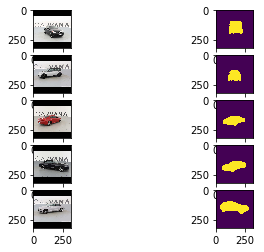

In [55]:
img, mask = next(train_generator)
print(mask[1,:,:,0].shape)
for i in range(img.shape[0]):
    plt.subplot(img.shape[0],2,2*i+1)
    plt.imshow(img[i,:,:,:])
    plt.subplot(img.shape[0],2,2*i+2)
    plt.imshow(mask[i,:,:,0])
    
plt.show()